<a href="https://colab.research.google.com/unit8co/AMLD2025/03_finetuning_and_rl/001_finetuning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning (& Reinforcement Learning)

In this notebook, we'll focus exclusively on working with local models. We'll explore three key aspects:
1. Evaluating how a small local model performs on coverage checks without any modifications
2. Enhancing the model's performance through Supervised Fine Tuning (SFT)
3. Investigating how reinforcement learning can improve the model's reasoning capabilities specifically for claim analysis (in the next notebook).

For this workshop, we'll use [Qwen2.5 3B](https://qwenlm.github.io/blog/qwen2.5/), which offers impressive performance despite its compact size. Note: The 3B version is licensed for non-commercial use only.

Our fine-tuning process will utilize [unsloth](https://docs.unsloth.ai/), a library that enables efficient LLM fine-tuning with minimal resources through several optimizations:
- By default implementation of [QLoRA](https://arxiv.org/abs/2305.14314) for 4-bit model loading
- Performance optimization via custom [OpenAI's triton](https://openai.com/index/triton/) CUDA kernels
- Enhanced inference speed using [vllm](https://github.com/vllm-project/vllm) (an optimized LLM inference server deployment framework)

Lastly, we'll leverage unsloth to implement Grouped Policy Optimization (GRPO) - the same technique used in DeepSeek R1 - to develop a specialized reasoning model for claim analysis in the next notebook.

### Qwen 2.5 baseline

Before we begin finetuning, we need to establish a baseline with our local model Qwen 2.5 3B.

#### load and prepare the dataset

We will load the same dataset used in the previous part of this workshop: 400 synthetic claims related to AXA UK's car insurance policy.

In [ ]:
%%capture
import sys

if "google.colab" in sys.modules:
    # clone the repo, install dependencies,
    !git clone https://github.com/unit8co/AMLD2025.git
    !curl -LsSf https://astral.sh/uv/install.sh | sh
    !/root/.local/bin/uv pip install --system -r AMLD2025/pyproject.toml

    # add cloned folder to python path to resolve import
    sys.path.insert(0, "AMLD2025/03_finetuning_and_rl")

In [ ]:
# we use pydantic models to help you navigate / type the dataset
from models import ClaimsDataset

with open("AMLD2025/data/claims_dataset_v2_manual.json", "r") as f:
    dataset = ClaimsDataset.model_validate_json(f.read())

print(f"loaded dataset with {len(dataset.root)} claims.")

loaded dataset with 400 claims.


In [ ]:
# you can use python 'help' to see the content of the pydantic model
from models import Claim

help(Claim)

Help on class Claim in module models:

class Claim(pydantic.main.BaseModel)
 |  Claim(*, description: str, explanation: str, coverage: bool, sources: list[models.Source], source_rule: models.SourceRuleContainer, limit_unit: str | None = None, limit_amount: float | None = None, limit_targets: list[str]) -> None
 |  
 |  Represents an individual insurance claim with all its details and
 |  associated rules.
 |  
 |  Attributes:
 |      description (str): Detailed description of the claim scenario
 |      explanation (str): Additional explanation or notes about the claim
 |      coverage (bool): Whether the claim is covered under the policy
 |      sources (list[Source]): Relevant policy document excerpts supporting
 |          the claim
 |      source_rule (SourceRuleContainer): Collection of rules applicable to
 |          the claim
 |      limit_unit (Optional[str]): Currency unit for the claim limit (e.g.,
 |          "GBP")
 |      limit_amount (Optional[float]): Maximum amount cover

In [ ]:
claims = dataset.root
covered_claims = [claim for claim in claims if claim.coverage]
not_covered_claims = [claim for claim in claims if not claim.coverage]

print(f"there are {len(covered_claims)} covered claims and {len(not_covered_claims)} not covered claims.")

there are 126 covered claims and 274 not covered claims.


The loaded dataset of 400 claims is notably unbalanced, with 68.5% not covered and 31.5% covered. When creating our train/test split, we'll need to monitor these proportions to maintain a representative distribution.

#### split train / test dataset

To ensure comparable results, we'll split the dataset into training and test sets. We'll establish our baseline using only the test set. The training set will be used to finetune the model, after which we'll evaluate the finetuned model on the test set.

Note: In a production environment, we would typically implement Stratified K-fold Cross Validation to maintain consistent covered/not-covered proportions across splits. For this workshop, we're keeping the approach straightforward.

In [ ]:
import random

# shuffle randomly the claims with reproducibility
random.seed(42)
random.shuffle(claims)

# keep 80% as training set, 20% as testing set.
split_ratio = 0.8
train_size = int(len(claims) * split_ratio)

train_claims = claims[:train_size]
test_claims = claims[train_size:]

print(f"split {len(claims)} claims into {len(train_claims)} training claims and {len(test_claims)} testing claims")

split 400 claims into 320 training claims and 80 testing claims


In [ ]:

covered_train_claims = [claim for claim in train_claims if claim.coverage]
not_covered_train_claims = [claim for claim in train_claims if not claim.coverage]

print(f"{len(covered_train_claims)*100/len(train_claims)}% covered, {len(not_covered_train_claims)*100/len(train_claims)}% not covered")

30.625% covered, 69.375% not covered


In [ ]:
covered_test_claims = [claim for claim in test_claims if claim.coverage]
not_covered_test_claims = [claim for claim in test_claims if not claim.coverage]

print(f"{len(covered_test_claims)*100/len(test_claims)}% covered, {len(not_covered_test_claims)*100/len(test_claims)}% not covered")

35.0% covered, 65.0% not covered


We see a slight difference in the proportion of covered not covered between our training and testing set that could potentially impact our end results. To do it better we could make a stratified split for example using sklearn.

### Establish baseline performance Qwen2.5(3B)

#### Model Definition

Start by loading the model for huggingface. Thanks to unsloth we can load the model directly quantized in 4bits which enable to save a lot of bandwidth and storage.

In [ ]:
from unsloth import FastLanguageModel

max_seq_length = 1024  # Can increase for longer reasoning traces
lora_rank = 64  # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # False for LoRA 16bit
    fast_inference=True,  # Enable vLLM fast inference
    max_lora_rank=lora_rank,
    gpu_memory_utilization=0.5,  # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],  # Remove QKVO if out of memory
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Enable long context finetuning
    random_state=3407,
)

==((====))==  Unsloth 2025.2.5: Fast Qwen2 patching. Transformers: 4.48.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 49.66%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 192.
Unsloth: vLLM's KV Cache can use up to 4.9 GB. Also swap space = 2 GB.
WARNING 02-13 13:48:44 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-13 13:49:00 config.py:542] This model supports multiple tasks: {'reward', 'classify', 'generate', 'embed', 'score'}. Def

[W213 13:49:03.550827073 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 02-13 13:49:03 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 02-13 13:49:09 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-13 13:49:24 model_runner.py:1115] Loading model weights took 2.2160 GB
INFO 02-13 13:49:24 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-13 13:49:28 worker.py:267] Memory profiling takes 3.42 seconds
INFO 02-13 13:49:28 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.32GiB
INFO 02-13 13:49:28 worker.py:267] model weights take 2.22GiB; non_torch_memory takes 0.05GiB; PyTorch activation peak memory takes 1.05GiB; the rest of the memory reserved for KV Cache is 4.01GiB.
INFO 02-13 13:49:28 executor_base.py:110] # CUDA blocks: 7300, # CPU blocks: 3640
INFO 02-13 13:49:28 executor_base.py:115] Maximum concurrency for 1024 tokens per request: 114.06x
INFO 02-13 13:49:30 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error oc

Capturing CUDA graph shapes: 100%|██████████| 27/27 [00:50<00:00,  1.86s/it]

INFO 02-13 13:50:20 model_runner.py:1562] Graph capturing finished in 50 secs, took 0.62 GiB
INFO 02-13 13:50:20 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 56.41 seconds



Unsloth 2025.2.5 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


If you are curious about what `get_peft_model` is doing:

Here we just load the model and apply peft which modify each relevant modules / layer from regular pytorch modules to LoRa adapted one as follow:

```python
# Original layer
class LinearLayer:
    def __init__(self):
        self.weight = Parameter(...)  # Full weight matrix
    
    def forward(self, x):
        return x @ self.weight.T
```

becomes

```python
# LoRA wrapped version
class LoRALayer:
    def __init__(self, base_layer, rank=8):
        self.base_layer = base_layer          # Original layer
        self.lora_A = Parameter(...)          # Low rank matrix A (smaller)
        self.lora_B = Parameter(...)          # Low rank matrix B (smaller)
        self.scaling = alpha / rank           # Scaling factor
        
    def forward(self, x):
        # Original computation
        base_output = self.base_layer(x)
        # LoRA computation
        lora_output = (x @ self.lora_A @ self.lora_B) * self.scaling
        # Combine both
        return base_output + lora_output
```

Additionaly the basebone model is loaded in 4bit which translate to using the following `BitsAndBytesConfig`:

```python
bnb_config = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = dtype,
)
```

This setup basically enable [QLoRA](https://arxiv.org/pdf/2305.14314) where the backbone model is quantised using nf4 (4 bit optimised quantisation).

We will then define the prompt that we will use to answer the coverage question. Feel free to experiment with different prompt here as it can significantly impact the accuracy already.

#### Prompt Definition

In [ ]:
PROMPT = """
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy based on the sources.

Claim description:
{claim.description}

Sources:
{sources}

Format:
Return only "covered" or "not covered"
""".strip()

In [ ]:
def claim_to_prompt(claim: Claim):
    """apply chat template and format the prompt"""
    return tokenizer.apply_chat_template(
        [
            {
                "role": "user",
                "content": PROMPT.format(
                    claim=claim,
                    sources="\n".join(
                        [
                            f"{i + 1}. {source.paragraph}"
                            for i, source in enumerate(claim.sources)
                        ]
                    ),
                ),
            }
        ],
        tokenize=False,
        add_generation_prompt=True,
    )

In [ ]:
prompts = [claim_to_prompt(claim) for claim in test_claims]
print(prompts[0])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy based on the sources.

Claim description:
I discovered someone had attempted to steal my car. The driver's side door lock was damaged, and the dashboard was dismantled, with the stereo missing. Is there any provision for covering transportation and accomodation?

Sources:
1. If your car, accessories or spare parts are lost, stolen or damaged, we will: - repair the damage; - replace what is lost or damaged and is too expensive to repair; or - pay you the cost of the loss or damage.
2. If your car is damaged, we will use one of our recommended repairers to repair it. If you choose not to use them, we may not pay more than our recommended repairer would have charged and we may choo

#### Inference

Before running inferences with our model and looking at the result it's good to check the size of the output so that we can limit the generation to only the amount of token needed.

Common approach today to build tokenizer is to use algorithm similar to Byte Pair Encoding (BPE) which is "trained" on a dataset and determines the amount of token for a specific word / set of words. I highly recommend this video from Andrej Karpathy to dive deeper into tokenizer if interested: [video](https://www.youtube.com/watch?v=zduSFxRajkE)

In [ ]:
print(f"num tokens covered: {len(tokenizer.tokenize('covered'))}")
print(f"num tokens not covered: {len(tokenizer.tokenize('not covered'))}")

num tokens covered: 1
num tokens not covered: 2


In here see that covered takes 1 token and 'not covered' takes 2 tokens so we will cap our generation to 2 tokens.

In [ ]:
from vllm import SamplingParams

sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2,  # set to 2 as not covered is 2 tokens
)
outputs = model.fast_generate(
    prompts,
    sampling_params=sampling_params,
    lora_request=None,
)

Processed prompts: 100%|██████████| 80/80 [00:14<00:00,  5.48it/s, est. speed input: 2009.20 toks/s, output: 10.96 toks/s]


In [ ]:
responses = []
for response_output in outputs:
    responses.append(response_output.outputs[0].text)

print(responses)

['not covered', 'covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not cov

#### Evaluation & Results

In [ ]:
print(
    f"Predicted {len([response for response in responses if response == 'covered'])} claims as covered"
)
print(
    f"Predicted {len([response for response in responses if response == 'not covered'])} claims as not covered"
)

Predicted 13 claims as covered
Predicted 67 claims as not covered


Already we observe here that the total amount is still 80 claims as the size of our test dataset which is already a very good result considering we are using a very small model: it perfectly followed the format instruction from the prompt.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_claims]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")


Accuracy: 0.7375
Precision: 0.7692307692307693
Recall: 0.35714285714285715
F1 Score: 0.4878048780487805


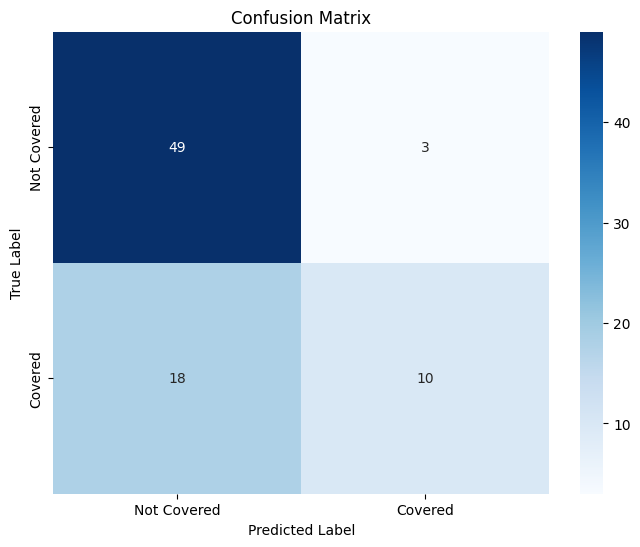

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert responses to boolean (True for 'covered', False for 'not covered')
y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_claims]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Covered", "Covered"],
    yticklabels=["Not Covered", "Covered"],
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

While we wait for the baseline model to run for everyone, here are several ways you can experiment with improving the model's performance:

1. Prompt Engineering
   - Modify the prompt structure and wording
   - Try different instruction formats
   - Add examples or context

2. LoRA Parameter Tuning
   - Adjust the LoRA rank (currently set to 64)
   - Modify target modules
   - Fine-tune the learning rate

3. Output Token Optimization
   - Experiment with alternative labels (e.g., "YES"/"NO" instead of "covered"/"not covered")
   - Try different response formats
   - Adjust max token length

Also note that the temperature is set to 0.8 which is usually quite high for such a task but useful in the case of GRPO in the second part.

Feel free to try these modifications to potentially improve the model's accuracy and performance.

## Supervised Fine-Tuning

Fine-tuning is the process of adjusting a machine learning model's weights to achieve specific goals. In modern LLM development, teams typically follow a three-stage process:

1. Pre-training
* Model starts with random weights
* Trained on vast amounts of internet data
* Objective: Optimize next token prediction accuracy

2. Supervised Fine-Tuning (SFT)
* Focus on teaching the model to follow instructions
* Creates "Instruct" model versions
* Uses smaller, higher-quality datasets
* Still employs next token prediction, but with curated instruction sets

3. Reinforcement Learning
* Further model improvement through self-learning
* Can include Human Feedback (RLHF)
* Model generates multiple alternatives
* Reward function (potentially human feedback) grades responses
* Model iteratively improves based on feedback

Resource Optimization for Colab Environment

While SFT typically demands significant computational resources, we can perform it in Colab using several optimization techniques:

1. Model Size
* Using a compact 3B parameter model
* Well-suited for Colab's T4 GPU limitations

2. LoRA (Low-Rank Adaptation)
* Instead of full model fine-tuning
* Tunes adapter layers in lower-rank space
* More efficient than full model training

3. Quantization
* Similar to QLoRA approach
* Backbone model remains in 4-bit precision
* LoRA weights and gradients computed in higher precision
* Maintains training stability while reducing memory usage

All of the above is easily achievable with the library we are using in this workshop: [unsloth](https://docs.unsloth.ai/)

### Dataset Preparation for SFT

In order to leverage hugging face trl SFTTrainer we first need to create a huggingface Dataset which will take care of creating the training batches and torch dataset based on the prompt text and the passed tokenizer

In [ ]:
# we create a huggingface dataset which makes it easy to load into a pytorch dataset
# and to use with the trl library / SFTTrainer

# we just need a text column for SFT (next token prediction)
from datasets import Dataset

dataset = Dataset.from_list(
    [
        {
            # we just add covered / not covered to the prompt
            # depending on the claim coverage
            "text": claim_to_prompt(claim)
            + ("covered" if claim.coverage else "not covered")
        }
        for claim in train_claims
    ]
)


In [ ]:
print(dataset[0]["text"])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
You are an Insurance Claim Expert.
You are given a claim description and a list of sources extracted from the insurance policy.
You need to determine if the claim is covered by the insurance policy based on the sources.

Claim description:
During a routine inspection, government officials arrived at the garage and declared that several car spare parts, including the catalytic converter and the exhaust system, were not compliant with new environmental regulations. Without prior notice, they ordered the immediate confiscation of these parts, citing the need to uphold public safety standards. Is there any recourse available for unexpected regulatory compliance issues?

Sources:
1. You are not covered for the following:
2. Confiscation or requisition or destruction by, or under the order of, any government or public or land authority.

Format:
Return only "covered" or "not cov

### Note on DataCollator

The DataCollator combine individual examples into training batches. It handles tokenization and padding of text sequences. It also ensures consistent input format for the model (usually and in this case torch tensor).

For our task of claim coverage check there are 2 SFT learning approaches that could be interesting and worth trying:

1. Full Sequence Learning
* Model learns from both prompt and output tokens
* May help model better understand the domain
* Requires more computational resources
* Common in API-based fine-tuning services

2. Completion-Only Learning
* Model learns only from the output tokens
* More resource-efficient
* Focused specifically on improving responses


- https://github.com/huggingface/trl/issues/632 trl issue where this is explained and there is no definite conclusion on the matter.
- https://huggingface.co/docs/trl/en/sft_trainer#train-on-completions-only we will train on completion only this time but feel free to explore with default.

In [ ]:
# collator is responsible to format the text into batch of inputs for the model
from trl import DataCollatorForCompletionOnlyLM

response_template = "<|im_start|>assistant\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

### Run the trainer / training loop

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences.
    args=TrainingArguments(
        per_device_train_batch_size=2,  # batch size = 2
        gradient_accumulation_steps=4,  # accumulate gradients 4 times -> equivalent to batch size 8
        warmup_steps=5,
        num_train_epochs=1,  # Set this for 1 full training run.
        # max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # Use this for WandB etc
    ),
    data_collator=collator,
)

torch.distributed process group is initialized, but parallel_mode != ParallelMode.DISTRIBUTED. In order to use Torch DDP, launch your script with `python -m torch.distributed.launch
torch.distributed process group is initialized, but parallel_mode != ParallelMode.DISTRIBUTED. In order to use Torch DDP, launch your script with `python -m torch.distributed.launch


Map (num_proc=2):   0%|          | 0/320 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 320 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 40
 "-____-"     Number of trainable parameters = 119,734,272


Step,Training Loss
1,1.025100
2,0.955000
3,0.955500
4,0.725300
5,0.427800
6,0.355700
7,0.809200
8,0.203800
9,0.445400
10,0.704600


### Perform Inference

In this section we perform inference again on the test dataset with the fine-tuned model to compare the results.

In [ ]:
from vllm import SamplingParams

sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2,  # set to 2 as not covered is 2 tokens
)
outputs = model.fast_generate(
    prompts,
    sampling_params=sampling_params,
    lora_request=None,
)

Processed prompts: 100%|██████████| 80/80 [00:13<00:00,  5.93it/s, est. speed input: 2176.94 toks/s, output: 11.87 toks/s]


In [ ]:
responses = []
for response_output in outputs:
    responses.append(response_output.outputs[0].text)

print(responses)

['not covered', 'covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'covered', 'covered', 'not covered', 'covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not covered', 'not cov

In [ ]:
print(
    f"Predicted {len([response for response in responses if response == 'covered'])} claims as covered"
)
print(
    f"Predicted {len([response for response in responses if response == 'not covered'])} claims as not covered"
)

Predicted 13 claims as covered
Predicted 67 claims as not covered


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_claims]

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"F1 Score: {f1_score(y_true, y_pred)}")

Accuracy: 0.7375
Precision: 0.7692307692307693
Recall: 0.35714285714285715
F1 Score: 0.4878048780487805


We know observe better results, we can tweak more to get even better results.

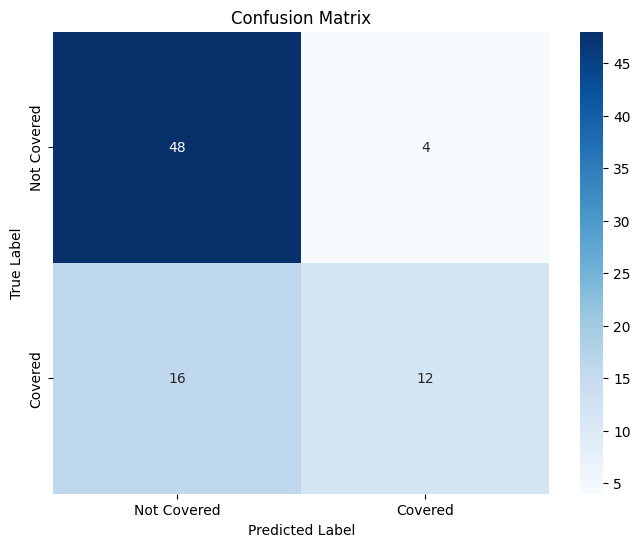

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert responses to boolean (True for 'covered', False for 'not covered')
y_pred = [response.strip() == "covered" for response in responses]
y_true = [claim.coverage for claim in test_dataset]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Covered", "Covered"],
    yticklabels=["Not Covered", "Covered"],
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Now it's your turn to experiment! While we achieved comparable results to our baseline, there's significant room for improvement. Here are some key areas you can explore:

1. Training Parameters
   - Adjust the learning rate (currently 2e-4)
   - Modify the number of epochs (currently 1)
   - Try different batch sizes or gradient accumulation steps
   - Experiment with different optimizers or scheduler types

2. Model Architecture
   - Modify the LoRA rank (currently 64)
   - Try different target modules for LoRA adaptation
   - Experiment with different quantization settings

3. Training Strategy
   - Switch from completion-only to full sequence learning
   - Try different prompt templates
   - Experiment with different response formats

Take some time to modify these parameters and observe their impact on the model's performance. Remember to:
- Keep track of your changes and their effects
- Compare metrics (accuracy, precision, recall, F1) across different configurations
- Consider the trade-offs between training time and performance improvements

What combination of parameters will you discover that leads to better results?